In [1]:
import os, sys, random
import numpy as np
import torch
import torch.nn as nn
from time import time
from tqdm import tqdm, trange
from termcolor import cprint
# import wandb
import matplotlib.pyplot as plt

from omegaconf import DictConfig, open_dict
import hydra
from hydra.utils import get_original_cwd

from torch.utils.data import DataLoader, RandomSampler, BatchSampler
import mne
sys.path.append('../')
from meg_decoding.models import get_model, Classifier
from meg_decoding.utils.get_dataloaders import get_dataloaders, get_samplers
from meg_decoding.utils.loss import *
from meg_decoding.dataclass.god import GODDatasetBase, GODCollator
from meg_decoding.utils.loggers import Pickleogger
from meg_decoding.utils.vis_grad import get_grad
from meg_decoding.matlab_utils.load_meg import get_meg_data, roi, time_window, get_baseline

from hydra import initialize, compose
with initialize(version_base=None, config_path="../../configs/"):
    args = compose(config_name='20230417_sbj01_seq2stat')
    
args.montage_path = '../' + args.montage_path
args.ch_region_path = '../' + args.ch_region_path

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In '20230417_sbj01_seq2stat': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


load  /work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_block001.mat
ROI:  ['occipital/left', 'occipital/right']
channel:  [129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
num channels:  22


/tmp/ipykernel_58587/4240435917.py:29: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mne.viz.plot_raw_psd(raw)


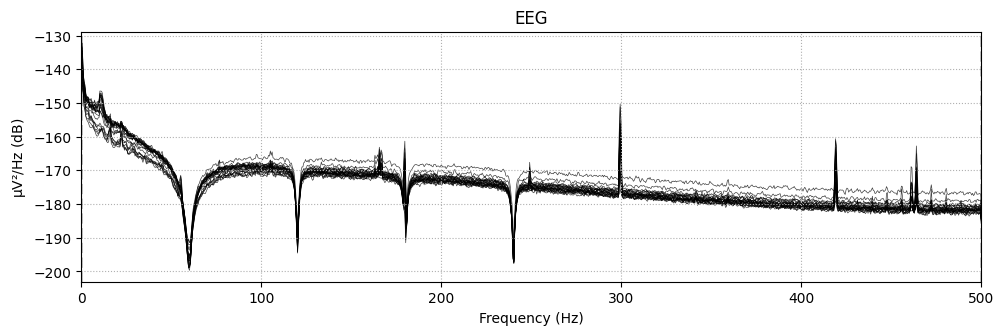

In [3]:

DATAROOT = args.data_root
processed_meg_path_pattern = os.path.join(DATAROOT, '{sub}/mat/{name}')
label_path_pattern = os.path.join(DATAROOT, '{sub}/labels/{name}')
trigger_meg_path_pattern = os.path.join(DATAROOT, '{sub}/trigger/{name}')
processed_rest_meg_path_pattern = os.path.join(DATAROOT, '{sub}/mat/{name}')
sub = 'sbj01'
split= 'train' # val
meg_name, label_name, trigger_name, rest_name = args.subjects[sub][split]['mat'][0], args.subjects[sub][split]['labels'][0], args.subjects[sub][split]['trigger'][0], args.subjects[sub][split]['rest'][0]


processed_meg_path = processed_meg_path_pattern.format(sub=sub, name=meg_name)
label_path = label_path_pattern.format(sub=sub, name=label_name)
trigger_path = trigger_meg_path_pattern.format(sub=sub, name=trigger_name)
processed_rest_meg_path = processed_rest_meg_path_pattern.format(sub=sub, name=rest_name)

MEG_Data, image_features, labels, triggers = get_meg_data(processed_meg_path, label_path, trigger_path,
                 rest_mean=None, rest_std=None, split=split)

roi_ids = roi(args)
data = MEG_Data[roi_ids,:]
# create raw
info = mne.create_info(
    ch_names=len(roi_ids),
    sfreq=1000,
    ch_types='eeg',
)
raw = mne.io.RawArray(data, info)

mne.viz.plot_raw_psd(raw)
plt.show()

In [51]:
split= 'train' # val
labels_list = []
features_list = []
for i in range(2):
    meg_name, label_name, trigger_name, rest_name = args.subjects[sub][split]['mat'][i], args.subjects[sub][split]['labels'][i], args.subjects[sub][split]['trigger'][i], args.subjects[sub][split]['rest'][i]
    processed_meg_path = processed_meg_path_pattern.format(sub=sub, name=meg_name)
    label_path = label_path_pattern.format(sub=sub, name=label_name)
    trigger_path = trigger_meg_path_pattern.format(sub=sub, name=trigger_name)
    processed_rest_meg_path = processed_rest_meg_path_pattern.format(sub=sub, name=rest_name)

    MEG_Data, image_features, labels, triggers = get_meg_data(processed_meg_path, label_path, trigger_path,
                 rest_mean=None, rest_std=None, split=split)
    labels_list.append(labels)
    features_list.append(image_features)

load  /work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_block001.mat
load  /work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_block002.mat


In [52]:
labels_arr = np.concatenate(labels_list)
image_features = np.concatenate(features_list, axis=0)
print(len(labels_arr), np.unique(labels_arr))
print(image_features.shape)

sorted_image_features = np.zeros_like(image_features)
for i, l in enumerate(labels_arr):
    sorted_image_features[l-1] = image_features[i]

1200 [   1    2    3 ... 1198 1199 1200]
(1200, 512)


In [53]:
print(labels_arr.shape)
a = np.unique(labels_arr)
a.sort()
print(len(a))
a

(1200,)
1200


array([   1,    2,    3, ..., 1198, 1199, 1200], dtype=uint16)

In [55]:
sorted_image_features[[0,1,2,600,601,602],10]

array([-0.16008864, -0.0097264 ,  0.06219969,  0.00605699,  0.48412266,
        0.5261386 ])

In [57]:
sorted_image_features[1200:]

array([], shape=(0, 512), dtype=float64)

In [58]:
np.save('../data/GOD/image_features_train.npy', sorted_image_features)

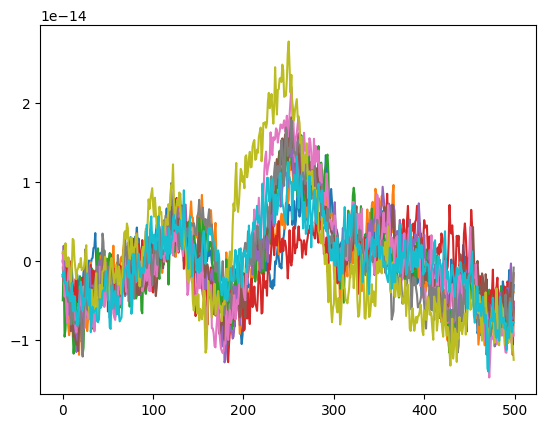

In [33]:
window = 500
MEG_epochs = []
for tr in triggers:
    t = int(tr * 1000)
    tmp_data = MEG_Data[:, t:t+window] - np.mean(MEG_Data[:, t-500:t], axis=1, keepdims=True)
    MEG_epochs.append(tmp_data)
    
MEG_epochs = np.stack(MEG_epochs, axis=0)
MEG_epochs = np.mean(MEG_epochs, axis=0)
for i in range(10):
    plt.plot(np.arange(window), MEG_epochs[i,:])
plt.show()

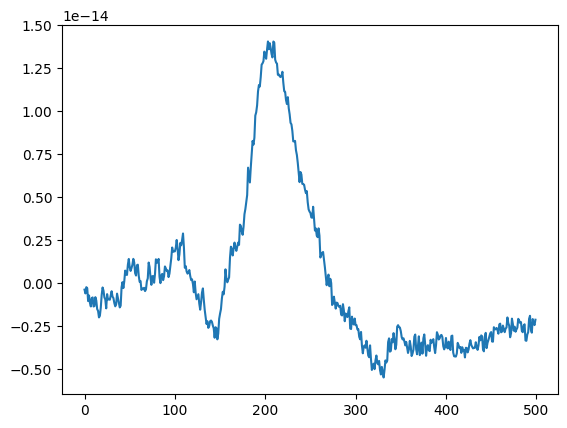

In [34]:

plt.plot(np.arange(window),  MEG_epochs[:160,:].mean(axis=0))
plt.show()

load  /work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_val001.mat
ROI:  ['occipital/left', 'occipital/right']
channel:  [129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
num channels:  22


/tmp/ipykernel_63164/1251308816.py:23: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mne.viz.plot_raw_psd(raw)


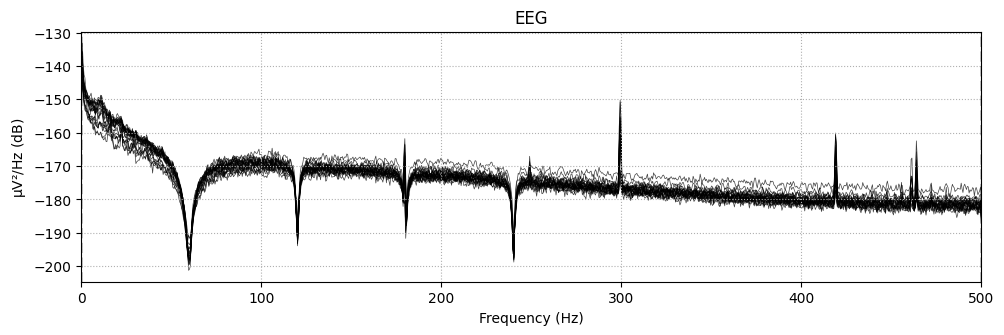

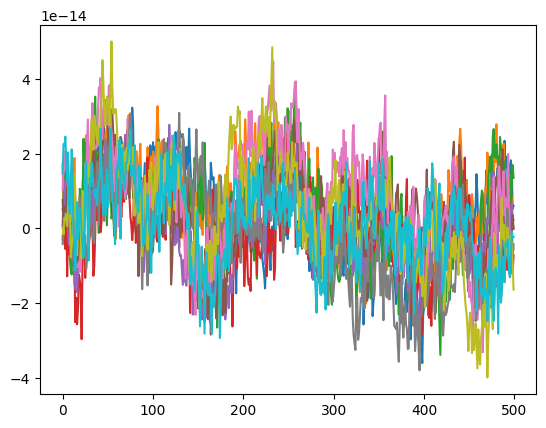

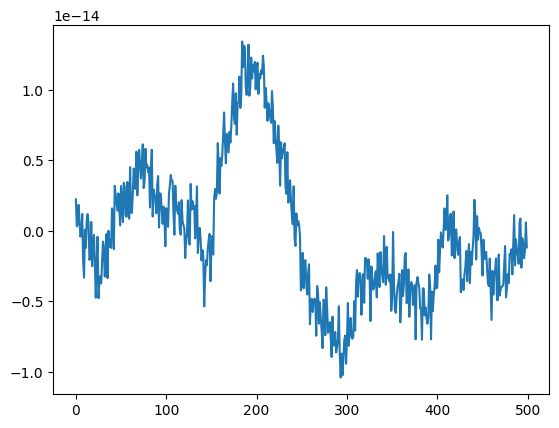

In [35]:
split= 'val' # val
meg_name, label_name, trigger_name, rest_name = args.subjects[sub][split]['mat'][0], args.subjects[sub][split]['labels'][0], args.subjects[sub][split]['trigger'][0], args.subjects[sub][split]['rest'][0]


processed_meg_path = processed_meg_path_pattern.format(sub=sub, name=meg_name)
label_path = label_path_pattern.format(sub=sub, name=label_name)
trigger_path = trigger_meg_path_pattern.format(sub=sub, name=trigger_name)
processed_rest_meg_path = processed_rest_meg_path_pattern.format(sub=sub, name=rest_name)

MEG_Data, image_features, labels, triggers = get_meg_data(processed_meg_path, label_path, trigger_path,
                 rest_mean=None, rest_std=None, split=split)

roi_ids = roi(args)
data = MEG_Data[roi_ids,:]
# create raw
info = mne.create_info(
    ch_names=len(roi_ids),
    sfreq=1000,
    ch_types='eeg',
)
raw = mne.io.RawArray(data, info)

mne.viz.plot_raw_psd(raw)
plt.show()
window = 500
MEG_epochs = []
for tr in triggers:
    t = int(tr * 1000)
    tmp_data = MEG_Data[:, t:t+window] - np.mean(MEG_Data[:, t-500:t], axis=1, keepdims=True)
    MEG_epochs.append(tmp_data)
    
MEG_epochs = np.stack(MEG_epochs, axis=0)
MEG_epochs = np.mean(MEG_epochs, axis=0)
for i in range(10):
    plt.plot(np.arange(window), MEG_epochs[i,:])
plt.show()

plt.plot(np.arange(window),  MEG_epochs[:160,:].mean(axis=0))
plt.show()

In [37]:
split= 'val' # val
labels_list = []
for i in range(6):
    meg_name, label_name, trigger_name, rest_name = args.subjects[sub][split]['mat'][i], args.subjects[sub][split]['labels'][i], args.subjects[sub][split]['trigger'][i], args.subjects[sub][split]['rest'][i]
    processed_meg_path = processed_meg_path_pattern.format(sub=sub, name=meg_name)
    label_path = label_path_pattern.format(sub=sub, name=label_name)
    trigger_path = trigger_meg_path_pattern.format(sub=sub, name=trigger_name)
    processed_rest_meg_path = processed_rest_meg_path_pattern.format(sub=sub, name=rest_name)

    MEG_Data, image_features, labels, triggers = get_meg_data(processed_meg_path, label_path, trigger_path,
                 rest_mean=None, rest_std=None, split=split)
    labels_list.append(labels)
    

load  /work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_val001.mat
load  /work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_val002.mat
load  /work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_val003.mat
load  /work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_val004.mat
load  /work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_val005.mat
load  /work/project/MEG_GOD/GOD_dataset/sbj01/mat/data_val006.mat


In [53]:
labels_arr = np.concatenate(labels_list)
print(len(labels_arr), np.unique(labels_arr))
print(image_features.shape)

sorted_image_features = np.zeros_like(image_features)
for i, l in enumerate(labels):
    sorted_image_features[l-1] = image_features[i]

300 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


In [55]:
sorted_image_features.shape

(50, 512)

In [57]:
np.save('../data/GOD/image_features.npy', sorted_image_features)

In [36]:
# To 120 Hz
print(MEG_Data.shape)
meg_resampled = mne.filter.resample(
    MEG_Data, down=1000 / 120,
)
print(meg_resampled.shape)


(203, 76000)
(203, 9120)


In [ ]:
from meg_decoding.utils.reproducibility import seed_worker
# NOTE: We do need it (IMHO).
if args.reproducible:
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.use_deterministic_algorithms(True)
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    g = torch.Generator()
    g.manual_seed(0)
    seed_worker = seed_worker
else:
    g = None
    seed_worker = None


train_dataset = GODDatasetBase(args, 'train')
val_dataset = GODDatasetBase(args, 'val')
with open_dict(args):
    args.num_subjects = train_dataset.num_subjects
    print('num subject is {}'.format(args.num_subjects))


if args.use_sampler:
    test_size = val_dataset.Y.shape[0]
    train_loader, test_loader = get_samplers(
        train_dataset,
        val_dataset,
        args,
        test_bsz=test_size,
        collate_fn=GODCollator(args),)

else:
    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        drop_last=True,
        shuffle=True,
        num_workers=args.num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g,
    )
    test_loader = DataLoader(
        val_dataset,
        batch_size=args.batch_size,
        drop_last=True,
        shuffle=False,
        num_workers=args.num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g,
    )
